Training One-Class SVM...
Training with features: ['absolute_orientation[0]', 'absolute_orientation[1]', 'absolute_orientation[2]', 'angular_velocity[0]', 'angular_velocity[1]', 'angular_velocity[2]', 'linear_acceleration[0]', 'linear_acceleration[1]', 'linear_acceleration[2]', 'acceleration_magnitude', 'angular_velocity_magnitude', 'pitch', 'roll', 'jerk[0]', 'jerk[1]', 'jerk[2]', 'jerk_magnitude']
Number of features: 17

Parameters: nu=0.01, gamma=scale
Score: 0.926

Parameters: nu=0.01, gamma=auto
Score: 0.926

Parameters: nu=0.01, gamma=0.1
Score: 0.886

Parameters: nu=0.01, gamma=0.01
Score: 0.982

Parameters: nu=0.05, gamma=scale
Score: 0.917

Parameters: nu=0.05, gamma=auto
Score: 0.917

Parameters: nu=0.05, gamma=0.1
Score: 0.877

Parameters: nu=0.05, gamma=0.01
Score: 0.950

Parameters: nu=0.1, gamma=scale
Score: 0.888

Parameters: nu=0.1, gamma=auto
Score: 0.888

Parameters: nu=0.1, gamma=0.1
Score: 0.866

Parameters: nu=0.1, gamma=0.01
Score: 0.902

Best parameters: {'nu': 0

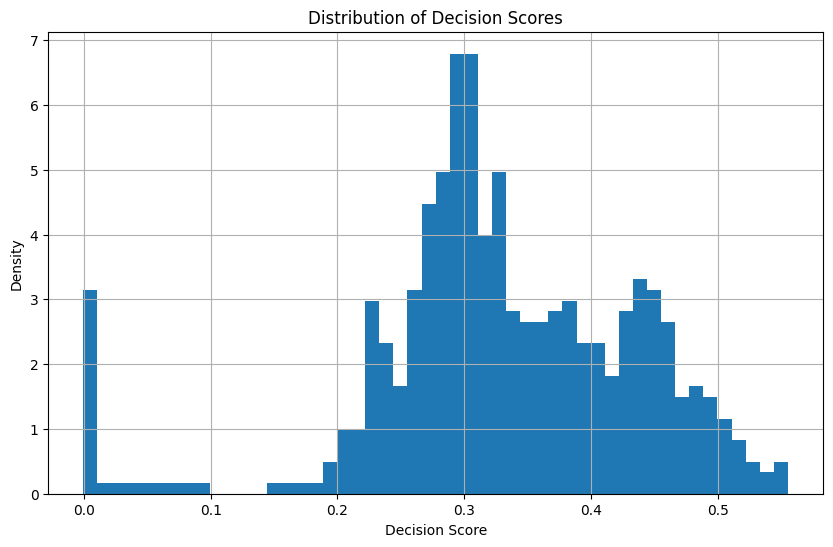


Saving model and related objects...


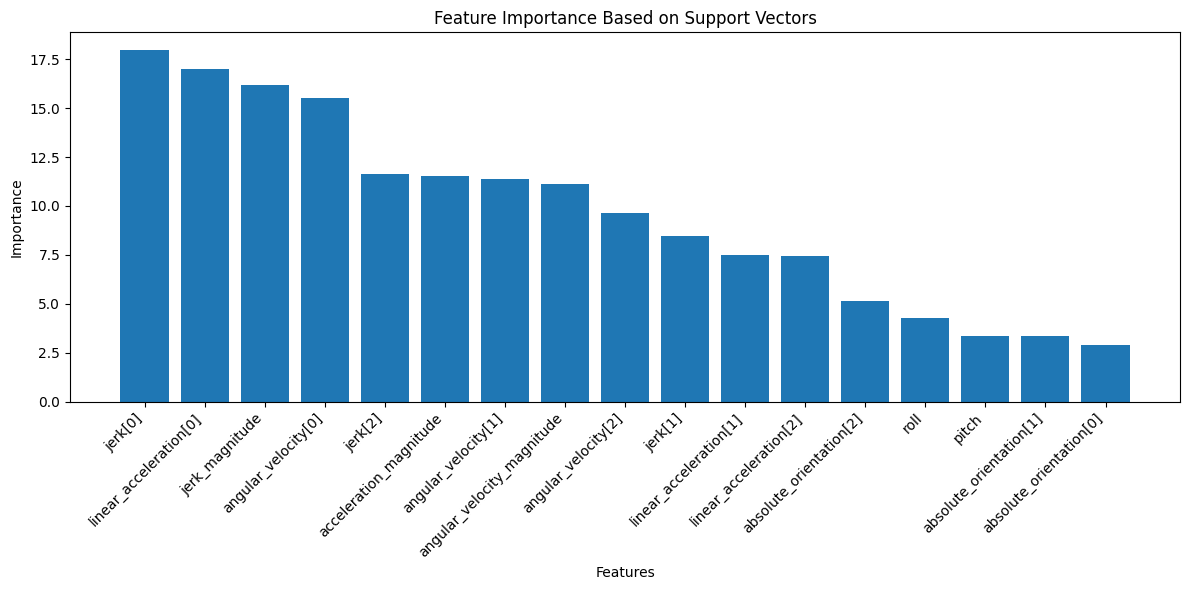


Top 5 most important features:
                   feature  importance
13                 jerk[0]   17.974798
6   linear_acceleration[0]   17.020108
16          jerk_magnitude   16.157139
3      angular_velocity[0]   15.529722
15                 jerk[2]   11.645964


In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
import joblib


def train_oneclass_svm(data):
    """
    Train and tune One-Class SVM for anomaly detection using all features
    
    Parameters:
    data (pd.DataFrame): Training dataset
    """
    # Define features (all columns except session_id and fall)
    feature_columns = [col for col in data.columns 
                      if col not in ['session_id', 'fall']]
    
    print("Training with features:", feature_columns)
    print(f"Number of features: {len(feature_columns)}")
    
    # Prepare the data
    X = data[feature_columns]
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Define parameter grid for One-Class SVM
    param_grid = {
        'nu': [0.01, 0.05, 0.1],  # Proportion of outliers
        'gamma': ['scale', 'auto', 0.1, 0.01]
    }
    
    # Grid search
    best_score = -np.inf
    best_params = None
    best_model = None
    
    for nu in param_grid['nu']:
        for gamma in param_grid['gamma']:
            model = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
            model.fit(X_scaled)
            
            # Predict
            predictions = model.predict(X_scaled)
            predictions = (predictions + 1) // 2
            
            # Calculate score
            score = np.mean(predictions)
            
            print(f"\nParameters: nu={nu}, gamma={gamma}")
            print(f"Score: {score:.3f}")
            
            if score > best_score:
                best_score = score
                best_params = {'nu': nu, 'gamma': gamma}
                best_model = model
    
    print("\nBest parameters:", best_params)
    print("Best score:", best_score)
    
    return best_model, scaler, feature_columns

def analyze_predictions(model, X_scaled, data):
    """
    Analyze model predictions
    """
    predictions = model.predict(X_scaled)
    predictions = (predictions + 1) // 2
    
    # Get decision function scores
    scores = model.decision_function(X_scaled)
    
    print("\nPrediction Analysis:")
    print(f"Number of normal samples: {sum(predictions == 1)}")
    print(f"Number of anomalies: {sum(predictions == 0)}")
    print(f"Percentage of data classified as normal: {np.mean(predictions)*100:.2f}%")
    
    # Plot decision scores distribution
    plt.figure(figsize=(10, 6))
    plt.hist(scores, bins=50, density=True)
    plt.title('Distribution of Decision Scores')
    plt.xlabel('Decision Score')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()
    
    return predictions, scores

# Load data
data = pd.read_csv('dataset/combined_training_data.csv')

# Train model
print("Training One-Class SVM...")
model, scaler, features = train_oneclass_svm(data)

# Scale data
X_scaled = scaler.transform(data[features])

# Analyze predictions
predictions, scores = analyze_predictions(model, X_scaled, data)

# Save model and related objects
print("\nSaving model and related objects...")
joblib.dump(model, 'oneclass_svm_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(features, 'features.joblib')

# Plot feature importance based on support vectors
sv_importance = np.abs(model.dual_coef_[0]).dot(np.abs(model.support_vectors_))
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': sv_importance
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance Based on Support Vectors')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# Print summary of most important features
print("\nTop 5 most important features:")
print(feature_importance.head())

In [38]:
from general import *
test = pd.read_csv('dataset/falls/b1.csv')
test = organize_columns(test)

Columns dropped: ['temperature', 'humidity', 'pressure', 'altitude', 'session_id']

Final column order:
['absolute_orientation[0]', 'absolute_orientation[1]', 'absolute_orientation[2]', 'angular_velocity[0]', 'angular_velocity[1]', 'angular_velocity[2]', 'linear_acceleration[0]', 'linear_acceleration[1]', 'linear_acceleration[2]', 'acceleration_magnitude', 'angular_velocity_magnitude', 'pitch', 'roll', 'jerk[0]', 'jerk[1]', 'jerk[2]', 'jerk_magnitude', 'fall']



Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.62      0.76        89
           1       0.24      1.00      0.39        11

    accuracy                           0.66       100
   macro avg       0.62      0.81      0.58       100
weighted avg       0.92      0.66      0.72       100



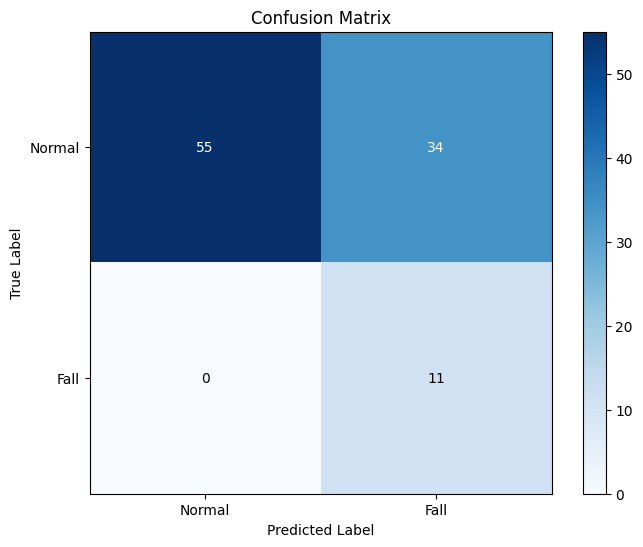

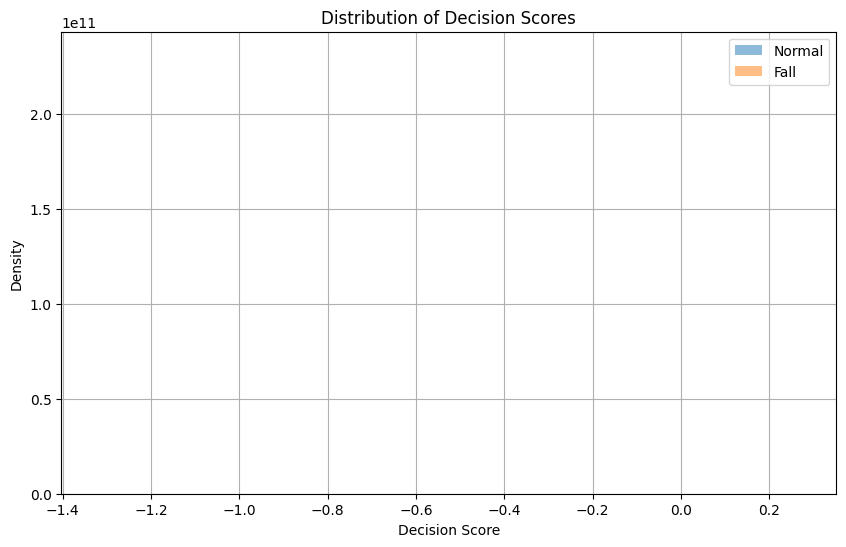


Number of misclassified cases: 34

Misclassified cases details:
True falls predicted as normal: 0
Normal cases predicted as falls: 34


In [39]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import joblib
import matplotlib.pyplot as plt

def test_predictions(test_data, model_path='oneclass_svm_model.joblib', 
                    scaler_path='scaler.joblib', features_path='features.joblib'):
    """
    Test One-Class SVM predictions on new data
    
    Parameters:
    test_data (pd.DataFrame): Test dataset with 'fall' labels
    model_path (str): Path to saved model
    scaler_path (str): Path to saved scaler
    features_path (str): Path to saved features list
    """
    # Load model and related objects
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    features = joblib.load(features_path)
    
    # Prepare test data
    X_test = test_data[features]
    y_true = test_data['fall']
    
    # Scale the features
    X_test_scaled = scaler.transform(X_test)
    
    # Get predictions
    predictions = model.predict(X_test_scaled)
    # Convert predictions: +1 (normal) -> 0, -1 (anomaly) -> 1
    predictions = (predictions == -1).astype(int)
    
    # Get decision scores
    scores = model.decision_function(X_test_scaled)
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, predictions))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_true, predictions)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks([0, 1], ['Normal', 'Fall'])
    plt.yticks([0, 1], ['Normal', 'Fall'])
    
    # Add text annotations to confusion matrix
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Plot decision scores distribution
    plt.figure(figsize=(10, 6))
    plt.hist(scores[y_true == 0], bins=50, alpha=0.5, label='Normal', density=True)
    plt.hist(scores[y_true == 1], bins=50, alpha=0.5, label='Fall', density=True)
    plt.title('Distribution of Decision Scores')
    plt.xlabel('Decision Score')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return predictions, scores

# Example usage:
def analyze_misclassifications(test_data, predictions):
    """
    Analyze misclassified cases
    """
    misclassified = test_data[predictions != test_data['fall']]
    print("\nNumber of misclassified cases:", len(misclassified))
    print("\nMisclassified cases details:")
    print("True falls predicted as normal:", sum((test_data['fall'] == 1) & (predictions == 0)))
    print("Normal cases predicted as falls:", sum((test_data['fall'] == 0) & (predictions == 1)))
    
    return misclassified


predictions, scores = test_predictions(test)
misclassified = analyze_misclassifications(test, predictions)


In [40]:
def plot_predictions_vs_true(test_data, predictions):
    """
    Plot acceleration magnitude with predicted and true falls
    
    Parameters:
    test_data (pd.DataFrame): Test dataset
    predictions (array): Model predictions (0 for normal, 1 for fall)
    """
    plt.figure(figsize=(15, 6))
    time = np.arange(len(test_data))
    
    # Plot base acceleration magnitude
    plt.plot(time, test_data['acceleration_magnitude'], 
            color='black', label='Acceleration Magnitude', linewidth=1)
    
    # Find continuous periods of fall predictions
    fall_periods = []
    start = None
    for i in range(len(predictions)):
        if predictions[i] == 1 and (start is None):
            start = i
        elif predictions[i] == 0 and (start is not None):
            fall_periods.append((start, i))
            start = None
    if start is not None:
        fall_periods.append((start, len(predictions)-1))
    
    # Add red shaded rectangles for fall periods
    y_min = min(test_data['acceleration_magnitude'])
    y_max = max(test_data['acceleration_magnitude'])
    for start, end in fall_periods:
        plt.axvspan(start, end, color='red', alpha=0.2, label='Abnormal Period' if start == fall_periods[0][0] else "")
    
    # Create empty scatter plots for legend
    plt.scatter([], [], color='red', s=50, label='Abnormal Conditions')
    plt.scatter([], [], color='blue', s=50, label='Falls')
    
    # Plot predictions, using blue for points that are both predicted and true falls
    for i in range(len(test_data)):
        if predictions[i] == 1:
            if test_data['fall'].iloc[i] == 1:
                # True fall that was detected - plot in blue
                plt.scatter(i, test_data['acceleration_magnitude'].iloc[i], 
                          color='blue', s=50)
            else:
                # False positive - plot in red
                plt.scatter(i, test_data['acceleration_magnitude'].iloc[i], 
                          color='red', s=50)
    
    plt.title('Acceleration Magnitude with Detected Falls')
    plt.xlabel('Time Steps')
    plt.ylabel('Acceleration Magnitude (m/s²)')
    plt.legend()
    plt.grid(True)
    plt.show()

## Normal walking


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        72
           1       0.00      0.00      0.00         0

    accuracy                           0.99        72
   macro avg       0.50      0.49      0.50        72
weighted avg       1.00      0.99      0.99        72



c:\Users\wacim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wacim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wacim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

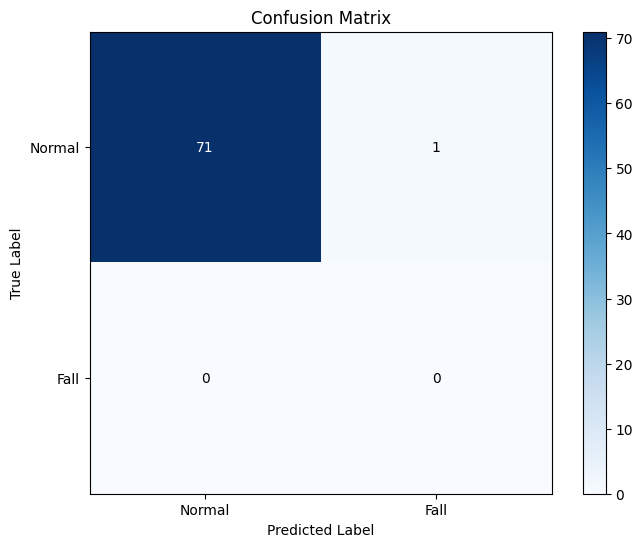

c:\Users\wacim\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


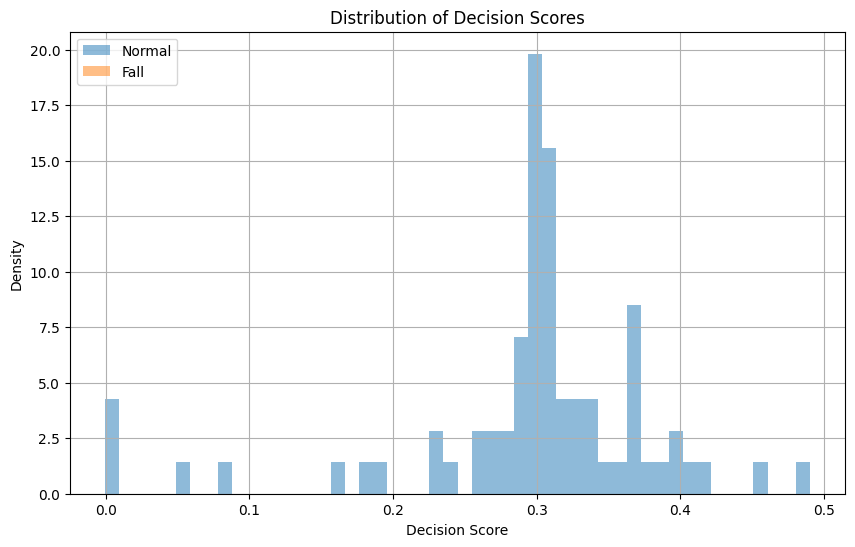


Number of misclassified cases: 1

Misclassified cases details:
True falls predicted as normal: 0
Normal cases predicted as falls: 1


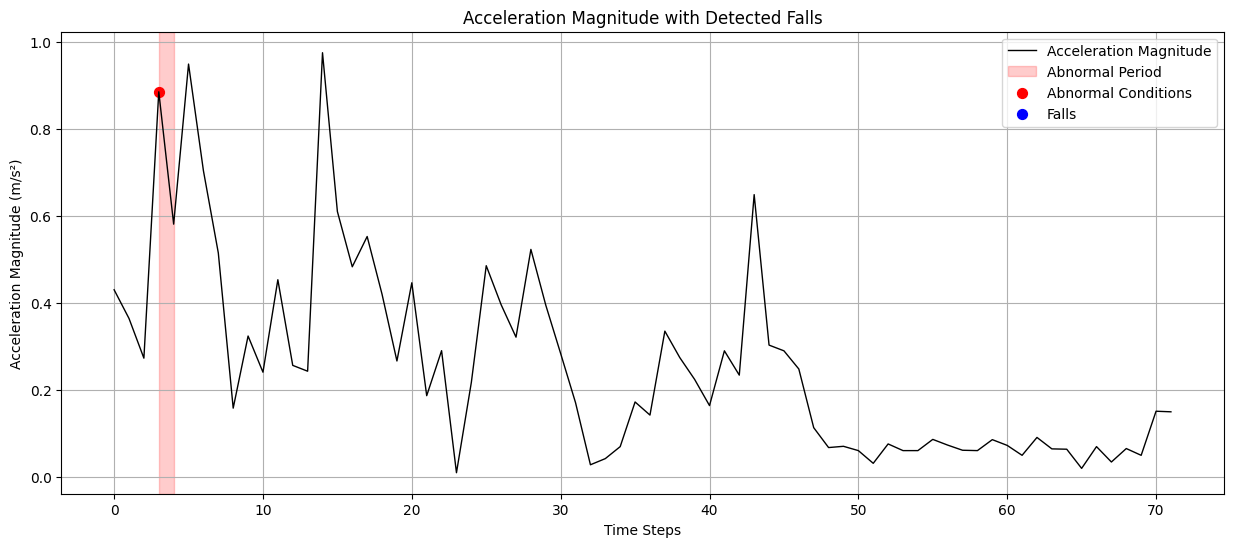

In [41]:
normal = pd.read_csv('dataset/normal/n1.csv')
predictions, scores = test_predictions(normal)
misclassified = analyze_misclassifications(normal, predictions)
plot_predictions_vs_true(normal, predictions)

## Test On sideFalls


Feature Statistics:

Acceleration Magnitude:
count    88.000000
mean      0.939784
std       1.457006
min       0.010000
25%       0.123769
50%       0.262673
75%       1.196103
max       8.454620
Name: acceleration_magnitude, dtype: float64

Angular Velocity Magnitude:
count     88.000000
mean      13.214830
std       28.399602
min        0.000000
25%        0.176696
50%        0.404948
75%        5.646541
max      111.531415
Name: angular_velocity_magnitude, dtype: float64

Jerk Magnitude:
count     88.000000
mean      21.301237
std       40.551548
min        0.000000
25%        1.095445
50%        3.893774
75%       21.497655
max      237.892917
Name: jerk_magnitude, dtype: float64

Basic Statistics:
       acceleration_magnitude
count               88.000000
mean                 0.939784
std                  1.457006
min                  0.010000
25%                  0.123769
50%                  0.262673
75%                  1.196103
max                  8.454620


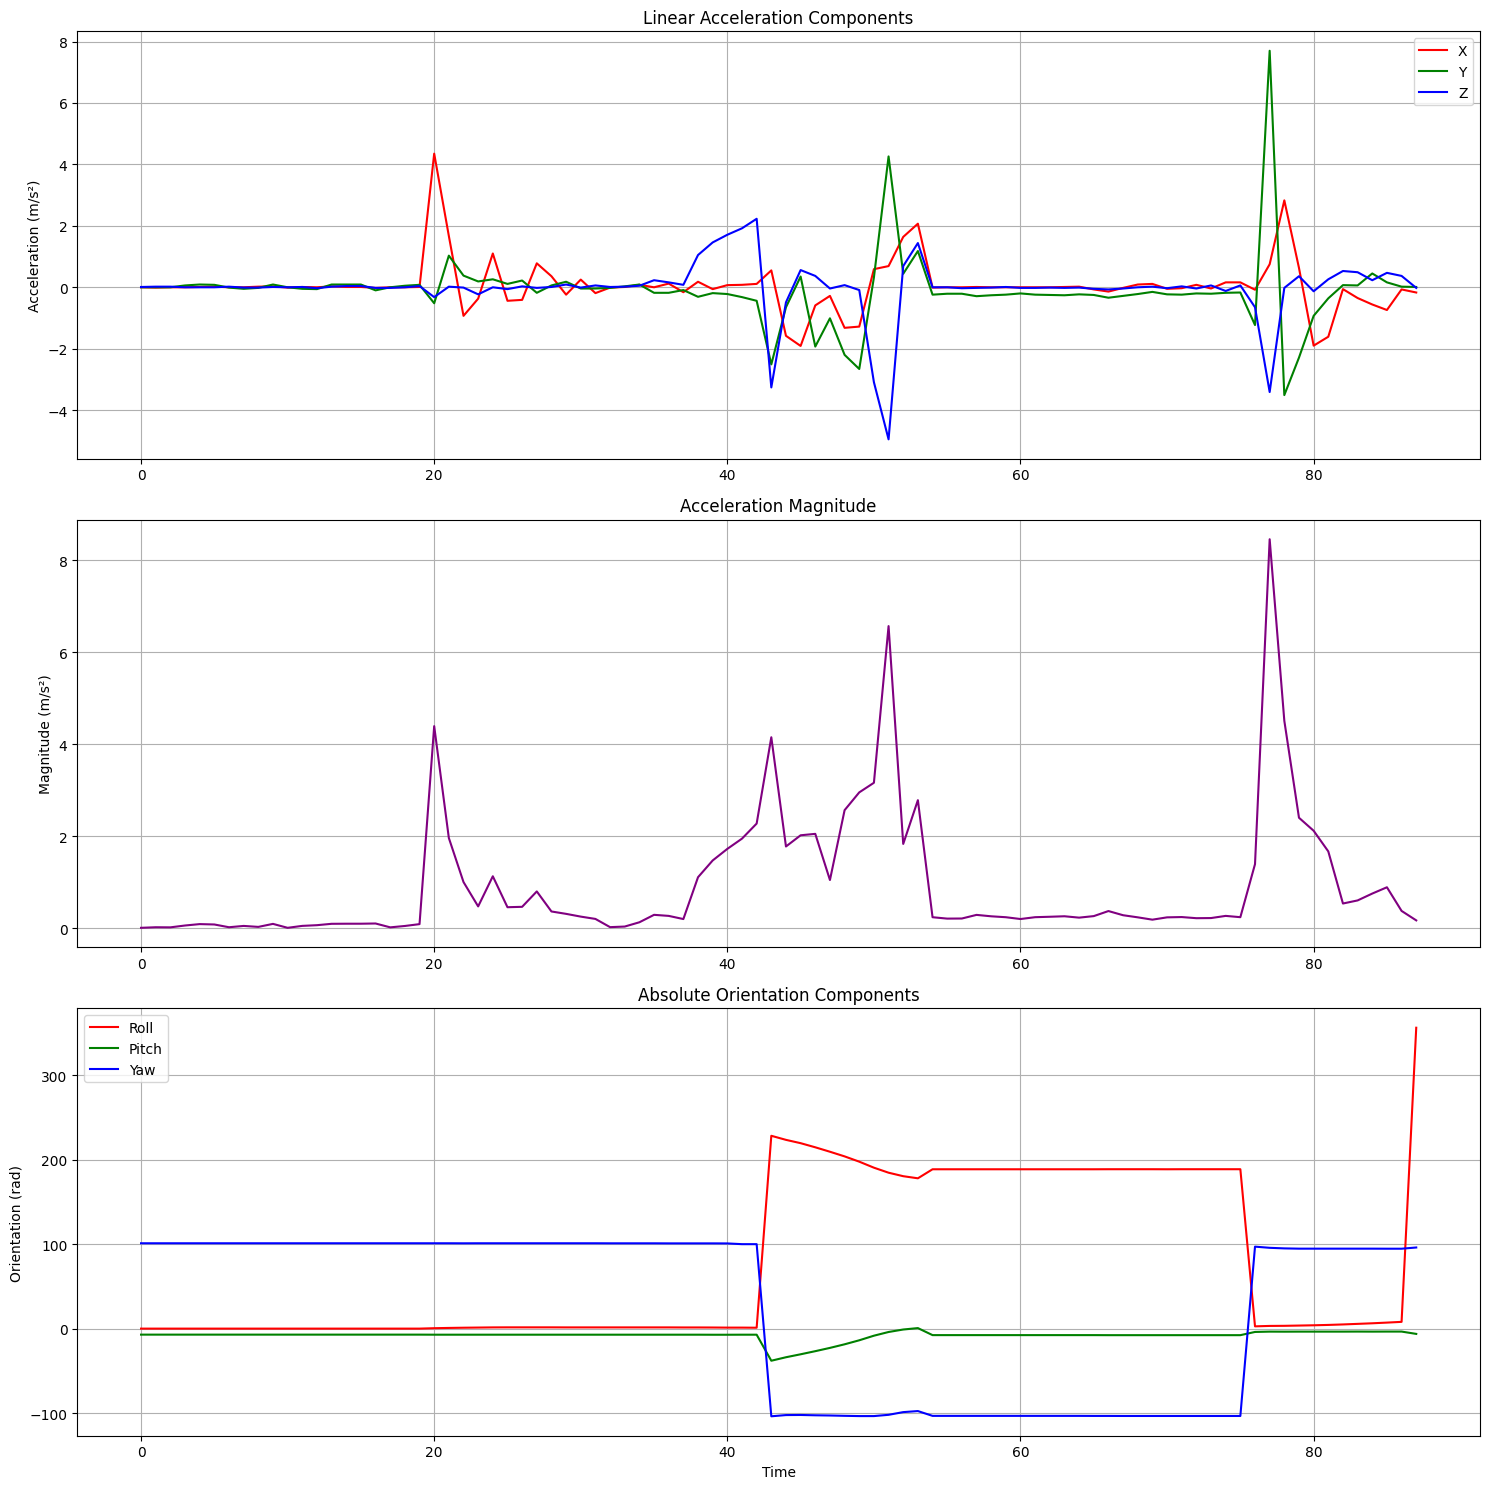

In [42]:
data = pd.read_csv('sessions/sideFalls/S29.csv')
compute_all_features(data)
plot_sensor_data(data)


In [43]:
data = compute_all_features(data)
def crop_fall2(file_path, start_index, fall_ranges, save_path=None):
    """
    Crop dataset and add fall labels based on two ranges
    
    Args:
        file_path (str): Path to the original CSV file
        start_index (int): Index to start from
        fall_ranges (list): List of tuples containing fall ranges [(start1, end1), (start2, end2)]
                          Each tuple contains start and end index relative to cropped data
        save_path (str, optional): Path to save the cropped CSV. If None, won't save
    
    Returns:
        pd.DataFrame: Cropped dataset with fall labels
    """
    # Validate fall_ranges
    if not isinstance(fall_ranges, list) or len(fall_ranges) != 2:
        raise ValueError("fall_ranges must be a list of exactly two tuples")
    
    if not all(isinstance(r, tuple) and len(r) == 2 for r in fall_ranges):
        raise ValueError("Each range must be a tuple of (start, end)")
        
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Crop from start_index
    cropped_df = df.iloc[start_index:]
    
    # Reset index
    cropped_df = cropped_df.reset_index(drop=True)
    
    # Add fall label column (initialize all to 0)
    cropped_df['fall'] = 0
    
    # Set fall=1 for each specified range
    for fall_start, fall_end in fall_ranges:
        cropped_df.loc[fall_start:fall_end, 'fall'] = 1
    
    # Save if path provided
    if save_path:
        cropped_df.to_csv(save_path, index=False)
        print(f"Saved cropped dataset to {save_path}")
    
    print(f"Original dataset length: {len(df)}")
    print(f"Cropped dataset length: {len(cropped_df)}")
    print(f"Number of fall samples: {cropped_df['fall'].sum()}")
    print("\nFall ranges:")
    for i, (start, end) in enumerate(fall_ranges, 1):
        print(f"Fall {i}: {start} to {end} (length: {end - start + 1})")
    
    return cropped_df

fall_ranges = [(20, 30), (55, 65)]  # Two fall ranges
df = crop_fall2('sessions/sideFalls/S29.csv', 
                start_index=20,
                fall_ranges=fall_ranges,
                save_path='dataset/falls/s1.csv')




Feature Statistics:

Acceleration Magnitude:
count    88.000000
mean      0.939784
std       1.457006
min       0.010000
25%       0.123769
50%       0.262673
75%       1.196103
max       8.454620
Name: acceleration_magnitude, dtype: float64

Angular Velocity Magnitude:
count     88.000000
mean      13.214830
std       28.399602
min        0.000000
25%        0.176696
50%        0.404948
75%        5.646541
max      111.531415
Name: angular_velocity_magnitude, dtype: float64

Jerk Magnitude:
count     88.000000
mean      21.301237
std       40.551548
min        0.000000
25%        1.095445
50%        3.893774
75%       21.497655
max      237.892917
Name: jerk_magnitude, dtype: float64
Saved cropped dataset to dataset/falls/s1.csv
Original dataset length: 88
Cropped dataset length: 68
Number of fall samples: 22

Fall ranges:
Fall 1: 20 to 30 (length: 11)
Fall 2: 55 to 65 (length: 11)


Columns dropped: ['temperature', 'humidity', 'pressure', 'altitude', 'session_id']

Final column order:
['absolute_orientation[0]', 'absolute_orientation[1]', 'absolute_orientation[2]', 'angular_velocity[0]', 'angular_velocity[1]', 'angular_velocity[2]', 'linear_acceleration[0]', 'linear_acceleration[1]', 'linear_acceleration[2]', 'acceleration_magnitude', 'angular_velocity_magnitude', 'pitch', 'roll', 'jerk[0]', 'jerk[1]', 'jerk[2]', 'jerk_magnitude', 'fall']

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.28      0.44        46
           1       0.40      1.00      0.57        22

    accuracy                           0.51        68
   macro avg       0.70      0.64      0.51        68
weighted avg       0.81      0.51      0.48        68



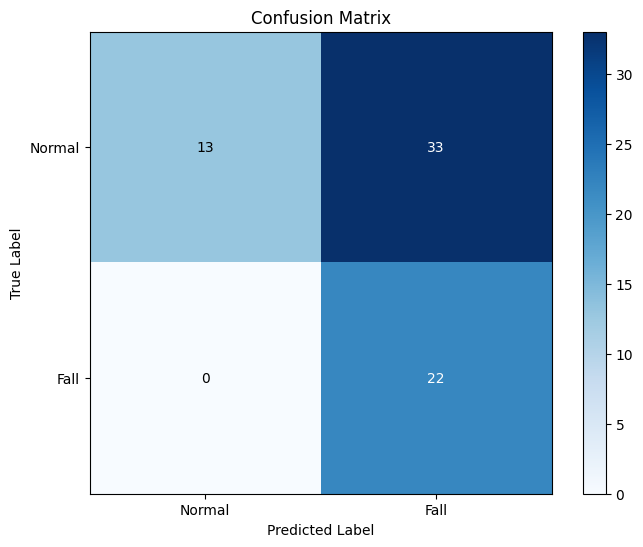

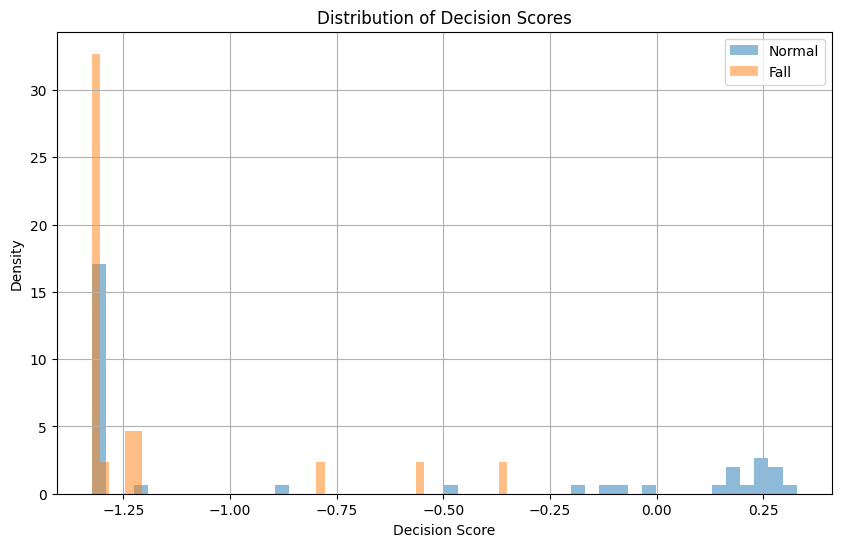


Number of misclassified cases: 33

Misclassified cases details:
True falls predicted as normal: 0
Normal cases predicted as falls: 33


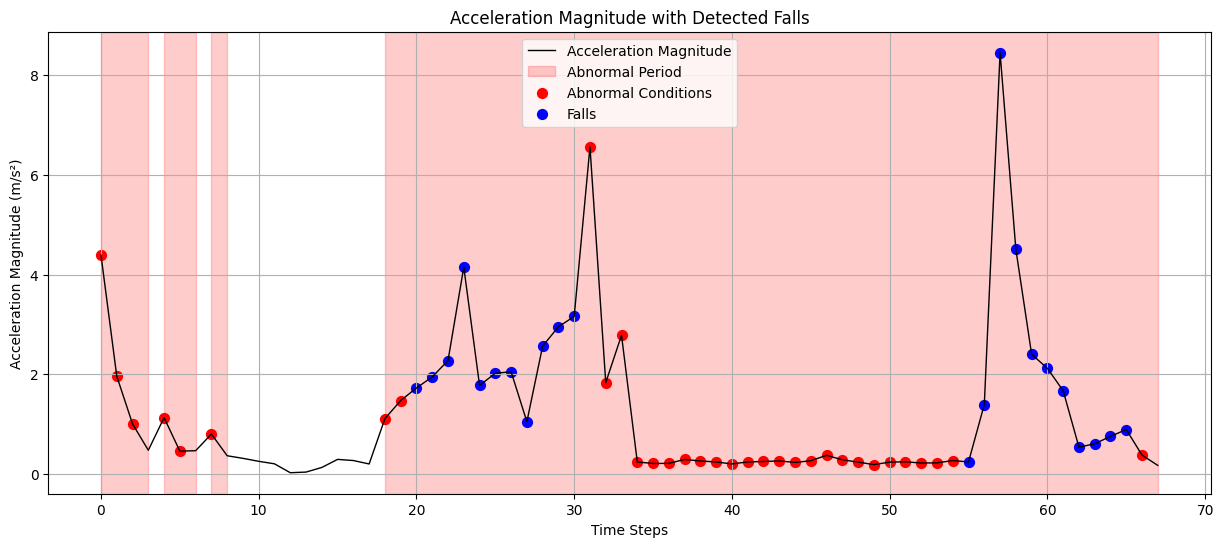

In [44]:
from general import organize_columns

data = pd.read_csv('dataset/falls/s1.csv')
data = organize_columns(data)
predictions, scores = test_predictions(data)
misclassified = analyze_misclassifications(data, predictions)
plot_predictions_vs_true(data, predictions)

## Front


Feature Statistics:

Acceleration Magnitude:
count    79.000000
mean      1.101775
std       2.000750
min       0.087750
25%       0.134907
50%       0.394715
75%       1.319788
max      14.857705
Name: acceleration_magnitude, dtype: float64

Angular Velocity Magnitude:
count    79.000000
mean      8.667694
std      15.335046
min       0.060000
25%       0.186924
50%       1.105532
75%       7.659984
max      57.776956
Name: angular_velocity_magnitude, dtype: float64

Jerk Magnitude:
count     79.000000
mean      25.895176
std       57.231916
min        0.000000
25%        1.376085
50%        7.914544
75%       24.481321
max      378.056662
Name: jerk_magnitude, dtype: float64

Basic Statistics:
       acceleration_magnitude
count               79.000000
mean                 1.101775
std                  2.000750
min                  0.087750
25%                  0.134907
50%                  0.394715
75%                  1.319788
max                 14.857705


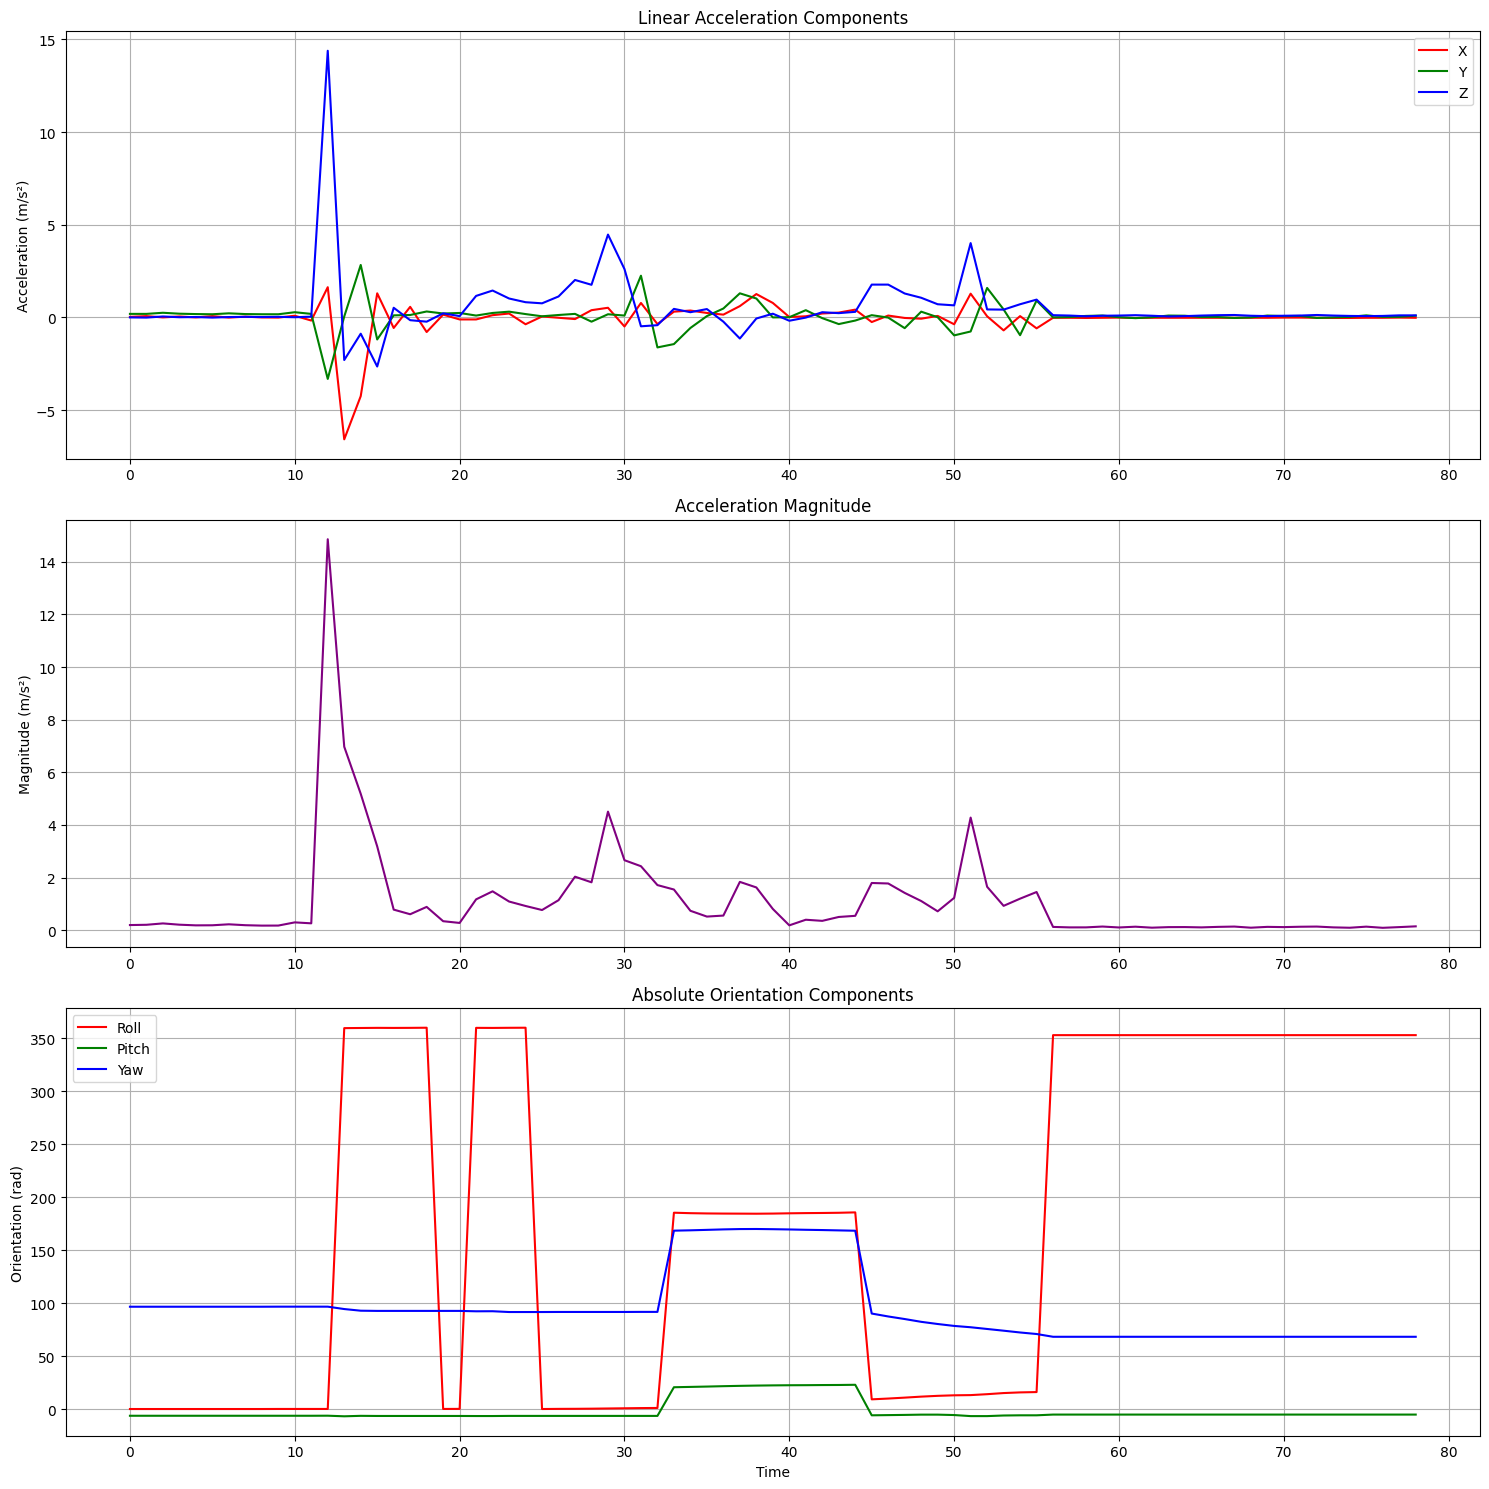

In [45]:
data = pd.read_csv('sessions/frontFalls/S26.csv')
compute_all_features(data)
plot_sensor_data(data)


In [46]:
cropped_data = crop_fall(
    file_path='sessions/frontFalls/S26.csv',
    start_index=0,
    fall_start=10,
    fall_end=20,
    save_path='dataset/falls/f1.csv'
)

Saved cropped dataset to dataset/falls/f1.csv
Original dataset length: 79
Cropped dataset length: 79
Number of fall samples: 11


Columns dropped: ['temperature', 'humidity', 'pressure', 'altitude', 'session_id']

Final column order:
['absolute_orientation[0]', 'absolute_orientation[1]', 'absolute_orientation[2]', 'angular_velocity[0]', 'angular_velocity[1]', 'angular_velocity[2]', 'linear_acceleration[0]', 'linear_acceleration[1]', 'linear_acceleration[2]', 'acceleration_magnitude', 'angular_velocity_magnitude', 'pitch', 'roll', 'jerk[0]', 'jerk[1]', 'jerk[2]', 'jerk_magnitude', 'fall']

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.22      0.34        68
           1       0.10      0.55      0.17        11

    accuracy                           0.27        79
   macro avg       0.43      0.38      0.26        79
weighted avg       0.66      0.27      0.32        79



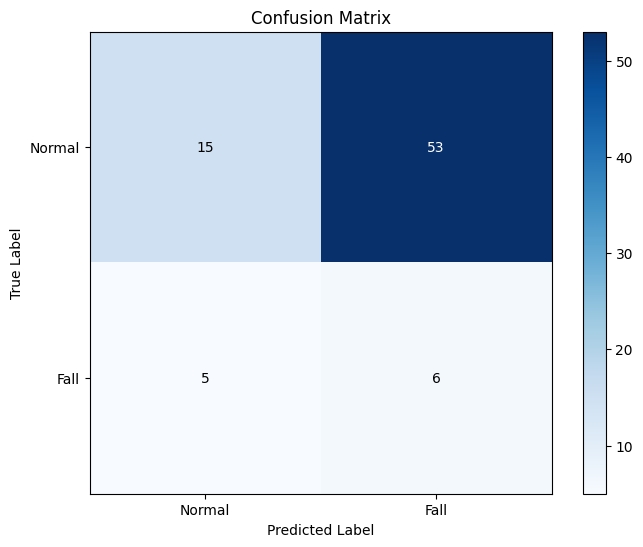

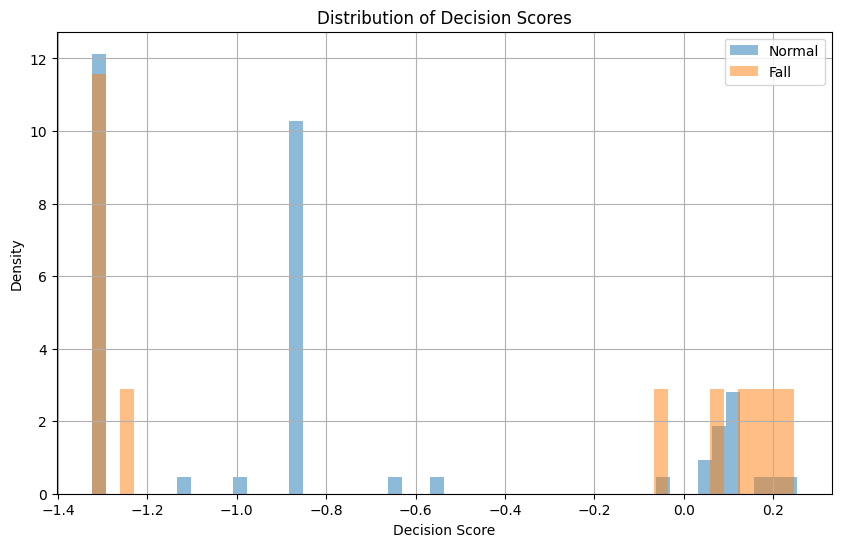


Number of misclassified cases: 58

Misclassified cases details:
True falls predicted as normal: 5
Normal cases predicted as falls: 53


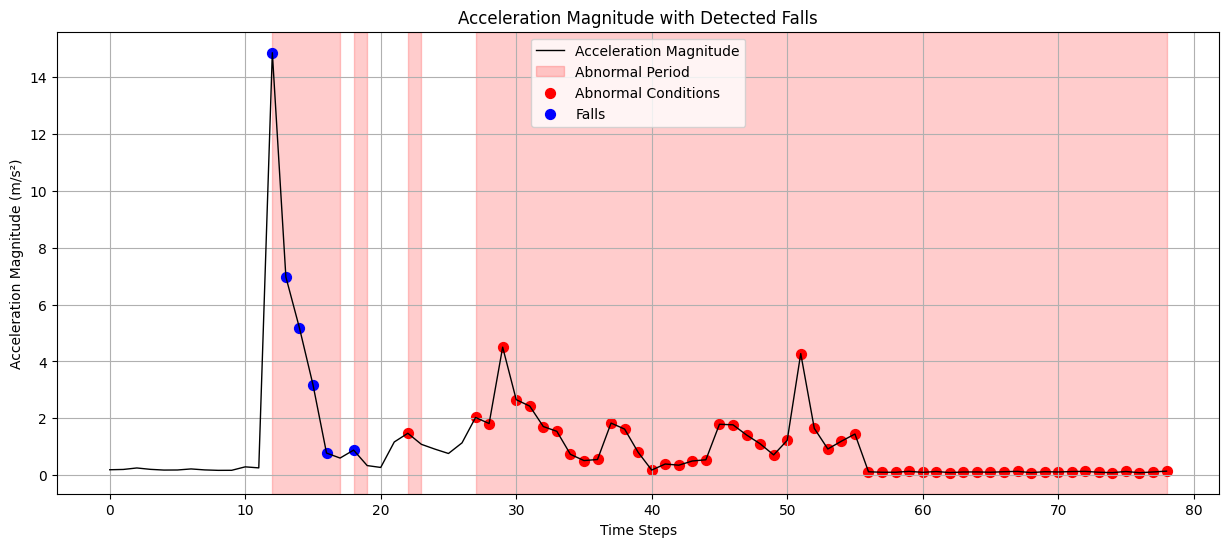

In [47]:
from general import organize_columns

data = pd.read_csv('dataset/falls/f1.csv')
data = organize_columns(data)
predictions, scores = test_predictions(data)
misclassified = analyze_misclassifications(data, predictions)
plot_predictions_vs_true(data, predictions)

Columns dropped: ['temperature', 'humidity', 'pressure', 'altitude', 'session_id']

Final column order:
['absolute_orientation[0]', 'absolute_orientation[1]', 'absolute_orientation[2]', 'angular_velocity[0]', 'angular_velocity[1]', 'angular_velocity[2]', 'linear_acceleration[0]', 'linear_acceleration[1]', 'linear_acceleration[2]', 'acceleration_magnitude', 'angular_velocity_magnitude', 'pitch', 'roll', 'jerk[0]', 'jerk[1]', 'jerk[2]', 'jerk_magnitude', 'fall']

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        72
           1       0.00      0.00      0.00         0

    accuracy                           0.99        72
   macro avg       0.50      0.49      0.50        72
weighted avg       1.00      0.99      0.99        72



c:\Users\wacim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wacim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wacim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

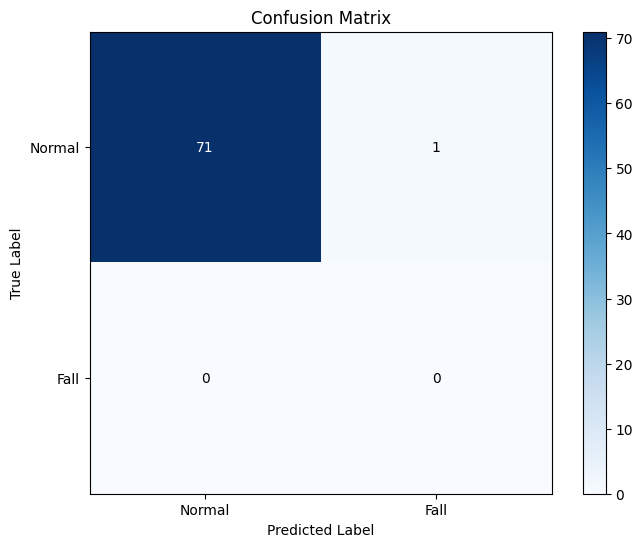

c:\Users\wacim\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


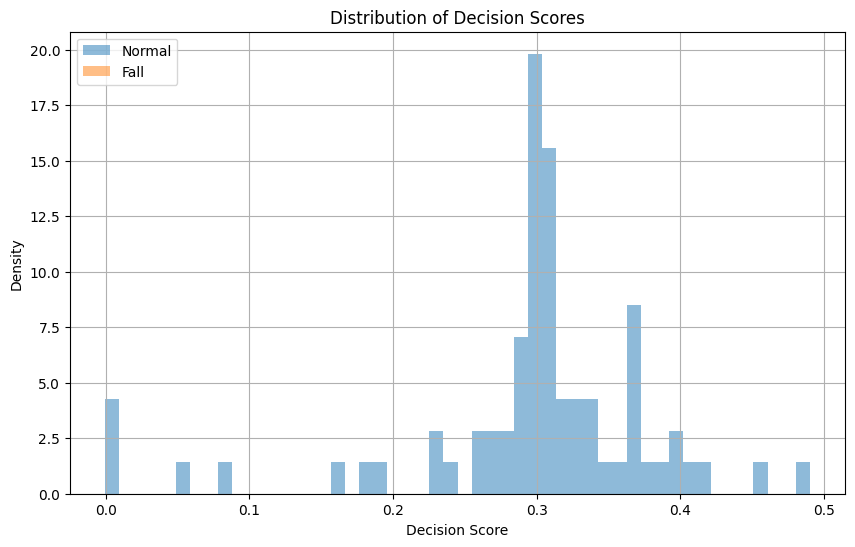


Number of misclassified cases: 1

Misclassified cases details:
True falls predicted as normal: 0
Normal cases predicted as falls: 1


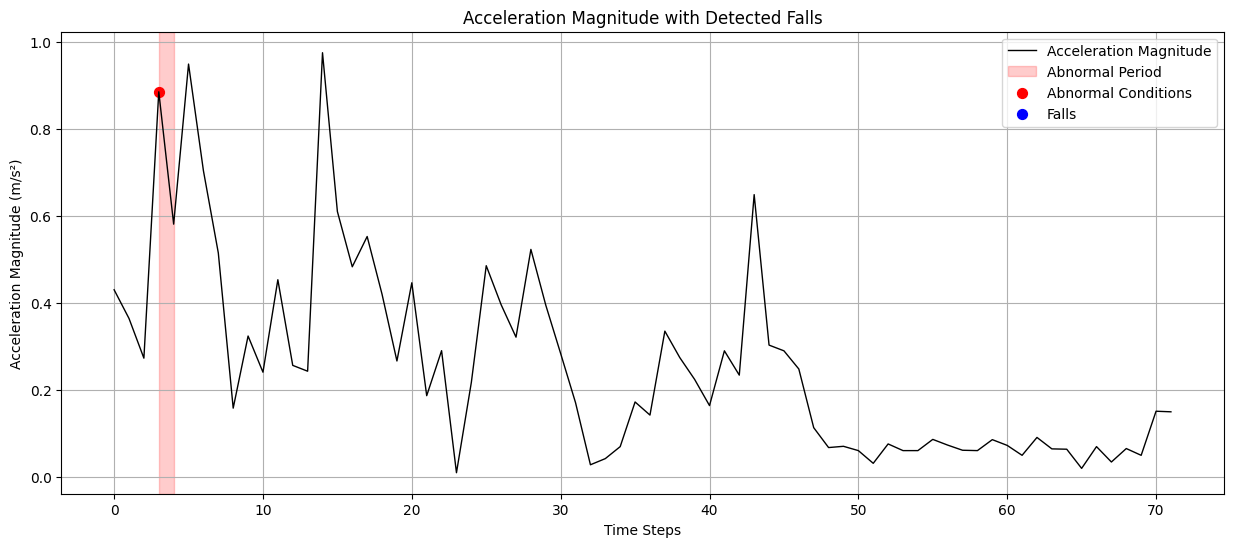

In [48]:
from general import organize_columns

data = pd.read_csv('dataset/normal/n1.csv')
data = organize_columns(data)
predictions, scores = test_predictions(data)
misclassified = analyze_misclassifications(data, predictions)
plot_predictions_vs_true(data, predictions)

Training One-Class SVM...
Training with features: ['absolute_orientation[0]', 'absolute_orientation[1]', 'absolute_orientation[2]', 'angular_velocity[0]', 'angular_velocity[1]', 'angular_velocity[2]', 'linear_acceleration[0]', 'linear_acceleration[1]', 'linear_acceleration[2]', 'acceleration_magnitude', 'angular_velocity_magnitude', 'pitch', 'roll', 'jerk[0]', 'jerk[1]', 'jerk[2]', 'jerk_magnitude']
Number of features: 17

Parameters: nu=0.01, gamma=scale
Score: 1.000

Parameters: nu=0.01, gamma=auto
Score: 1.000

Parameters: nu=0.01, gamma=0.1
Score: 1.000

Parameters: nu=0.01, gamma=0.01
Score: 1.000

Parameters: nu=0.05, gamma=scale
Score: 0.998

Parameters: nu=0.05, gamma=auto
Score: 0.998

Parameters: nu=0.05, gamma=0.1
Score: 1.000

Parameters: nu=0.05, gamma=0.01
Score: 1.000

Parameters: nu=0.1, gamma=scale
Score: 0.998

Parameters: nu=0.1, gamma=auto
Score: 0.998

Parameters: nu=0.1, gamma=0.1
Score: 0.998

Parameters: nu=0.1, gamma=0.01
Score: 1.000

Best parameters: {'nu': 0

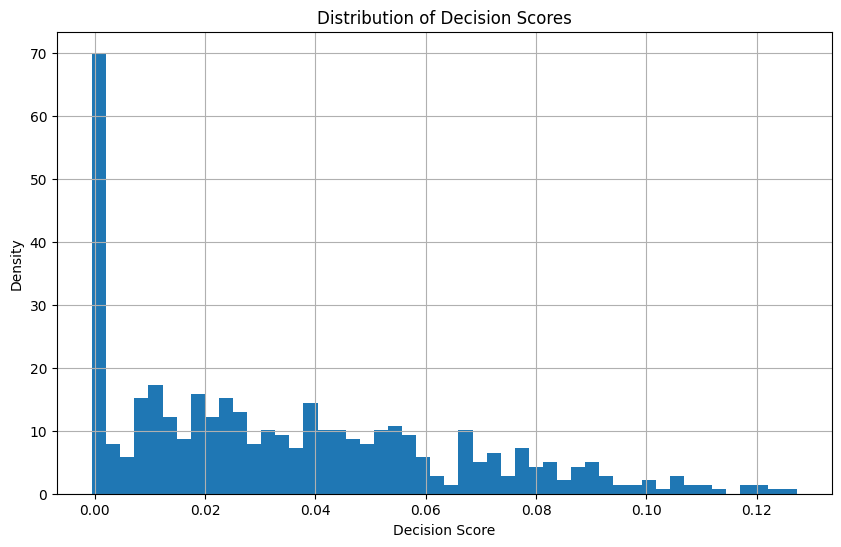


Saving model and related objects...


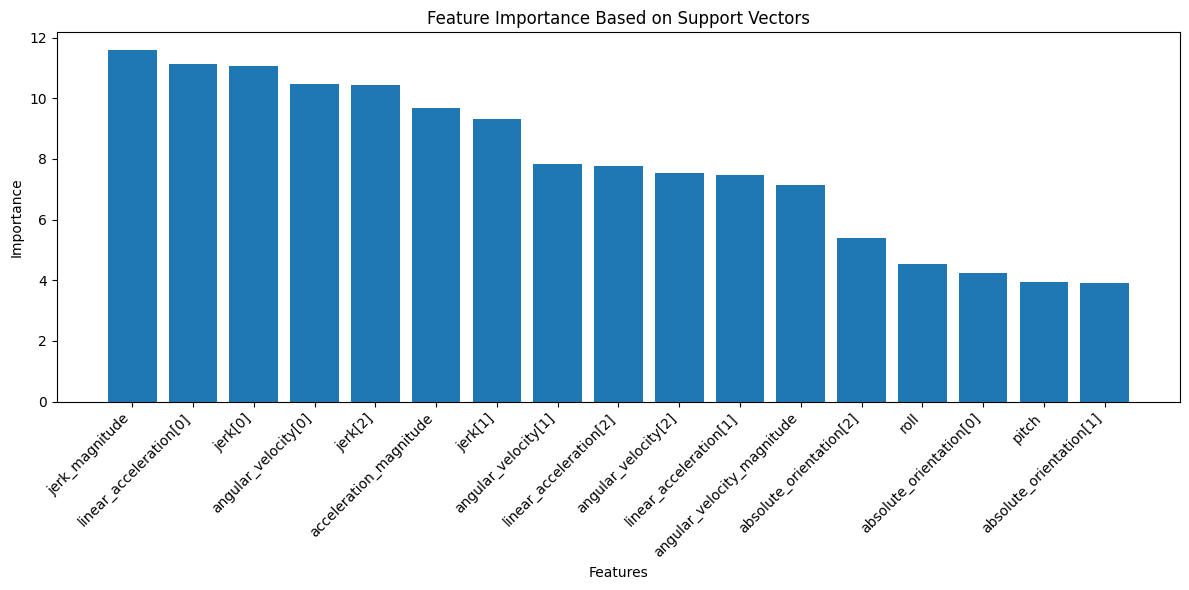


Top 5 most important features:
                   feature  importance
16          jerk_magnitude   11.597465
6   linear_acceleration[0]   11.124079
13                 jerk[0]   11.079121
3      angular_velocity[0]   10.461925
15                 jerk[2]   10.438950


In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
import joblib

def check_acceleration_constraint(data, predictions, window_size=10, acc_threshold=6.0):
    """
    Modify predictions based on acceleration magnitude constraint
    
    Parameters:
    data (pd.DataFrame): Dataset containing acceleration magnitude
    predictions (np.array): Original predictions from SVM
    window_size (int): Number of time steps to check after potential fall
    acc_threshold (float): Minimum acceleration magnitude to maintain fall prediction
    
    Returns:
    np.array: Modified predictions
    """
    modified_predictions = predictions.copy()
    
    # Get indices where falls are predicted
    fall_indices = np.where(predictions == 0)[0]
    
    for idx in fall_indices:
        # Check if we have enough data points after the current index
        if idx + window_size < len(data):
            # Get acceleration magnitude for the next window_size timesteps
            future_acc = data.iloc[idx:idx + window_size]['acceleration_magnitude'].values
            # If acceleration stays below threshold, change prediction to normal
            if np.all(future_acc < acc_threshold):
                modified_predictions[idx] = 1
                
    return modified_predictions

def train_oneclass_svm(data):
    """
    Train and tune One-Class SVM for anomaly detection using all features
    """
    # Define features (all columns except session_id and fall)
    feature_columns = [col for col in data.columns 
                      if col not in ['session_id', 'fall']]
    
    print("Training with features:", feature_columns)
    print(f"Number of features: {len(feature_columns)}")
    
    # Prepare the data
    X = data[feature_columns]
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Define parameter grid for One-Class SVM
    param_grid = {
        'nu': [0.01, 0.05, 0.1],
        'gamma': ['scale', 'auto', 0.1, 0.01]
    }
    
    # Grid search
    best_score = -np.inf
    best_params = None
    best_model = None
    
    for nu in param_grid['nu']:
        for gamma in param_grid['gamma']:
            model = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
            model.fit(X_scaled)
            
            # Predict
            predictions = model.predict(X_scaled)
            predictions = (predictions + 1) // 2
            
            # Apply acceleration constraint
            modified_predictions = check_acceleration_constraint(data, predictions)
            
            # Calculate score
            score = np.mean(modified_predictions)
            
            print(f"\nParameters: nu={nu}, gamma={gamma}")
            print(f"Score: {score:.3f}")
            
            if score > best_score:
                best_score = score
                best_params = {'nu': nu, 'gamma': gamma}
                best_model = model
    
    print("\nBest parameters:", best_params)
    print("Best score:", best_score)
    
    return best_model, scaler, feature_columns

def analyze_predictions(model, X_scaled, data):
    """
    Analyze model predictions with acceleration constraint
    """
    # Get initial predictions
    predictions = model.predict(X_scaled)
    predictions = (predictions + 1) // 2
    
    # Apply acceleration constraint
    modified_predictions = check_acceleration_constraint(data, predictions)
    
    # Get decision function scores
    scores = model.decision_function(X_scaled)
    
    print("\nPrediction Analysis:")
    print("Original predictions:")
    print(f"Number of normal samples: {sum(predictions == 1)}")
    print(f"Number of anomalies: {sum(predictions == 0)}")
    print(f"Percentage of data classified as normal: {np.mean(predictions)*100:.2f}%")
    
    print("\nModified predictions (with acceleration constraint):")
    print(f"Number of normal samples: {sum(modified_predictions == 1)}")
    print(f"Number of anomalies: {sum(modified_predictions == 0)}")
    print(f"Percentage of data classified as normal: {np.mean(modified_predictions)*100:.2f}%")
    
    # Plot decision scores distribution
    plt.figure(figsize=(10, 6))
    plt.hist(scores, bins=50, density=True)
    plt.title('Distribution of Decision Scores')
    plt.xlabel('Decision Score')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()
    
    return modified_predictions, scores

# Main execution
if __name__ == "__main__":
    # Load data
    data = pd.read_csv('dataset/combined_training_data.csv')

    # Train model
    print("Training One-Class SVM...")
    model, scaler, features = train_oneclass_svm(data)

    # Scale data
    X_scaled = scaler.transform(data[features])

    # Analyze predictions
    predictions, scores = analyze_predictions(model, X_scaled, data)

    # Save model and related objects
    print("\nSaving model and related objects...")
    joblib.dump(model, 'oneclass_svm_model.joblib')
    joblib.dump(scaler, 'scaler.joblib')
    joblib.dump(features, 'features.joblib')

    # Plot feature importance
    sv_importance = np.abs(model.dual_coef_[0]).dot(np.abs(model.support_vectors_))
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': sv_importance
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 6))
    plt.bar(feature_importance['feature'], feature_importance['importance'])
    plt.xticks(rotation=45, ha='right')
    plt.title('Feature Importance Based on Support Vectors')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

    print("\nTop 5 most important features:")
    print(feature_importance.head())


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.22      0.37        89
           1       0.14      1.00      0.24        11

    accuracy                           0.31       100
   macro avg       0.57      0.61      0.30       100
weighted avg       0.91      0.31      0.35       100



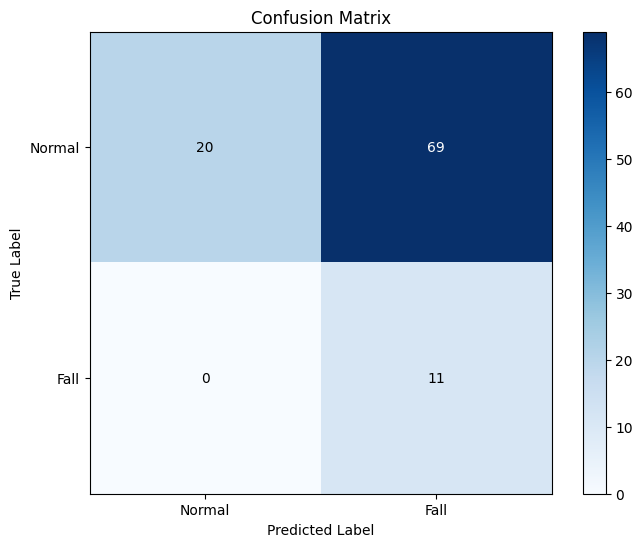

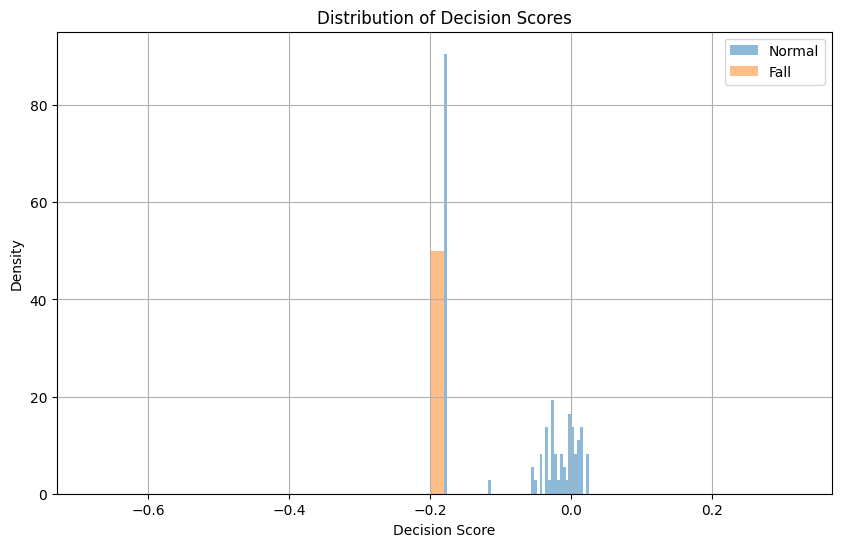

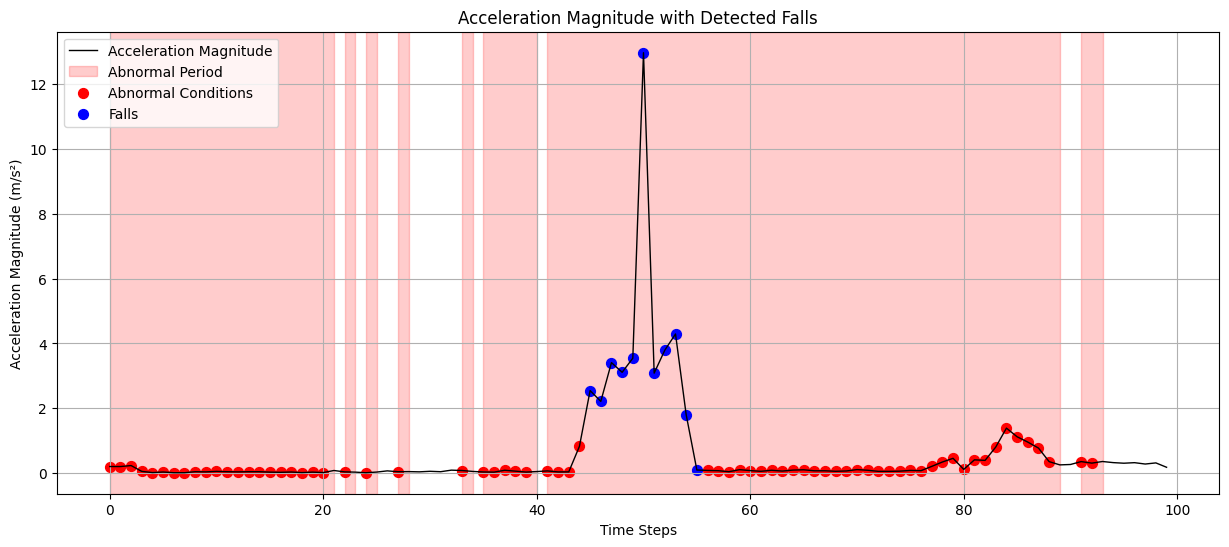

In [50]:
# First do your predictions
predictions, scores = test_predictions(test)
# Use the function
plot_predictions_vs_true(test, predictions)